<a href="https://www.kaggle.com/code/mdsayebgub/xception-lstm-on-ucf-85?scriptVersionId=248180118" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import TimeDistributed, Dropout, Flatten, Dense, LSTM
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
import random
import warnings
warnings.filterwarnings('ignore')

2025-06-30 16:02:52.494656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751299372.681714      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751299372.732699      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]

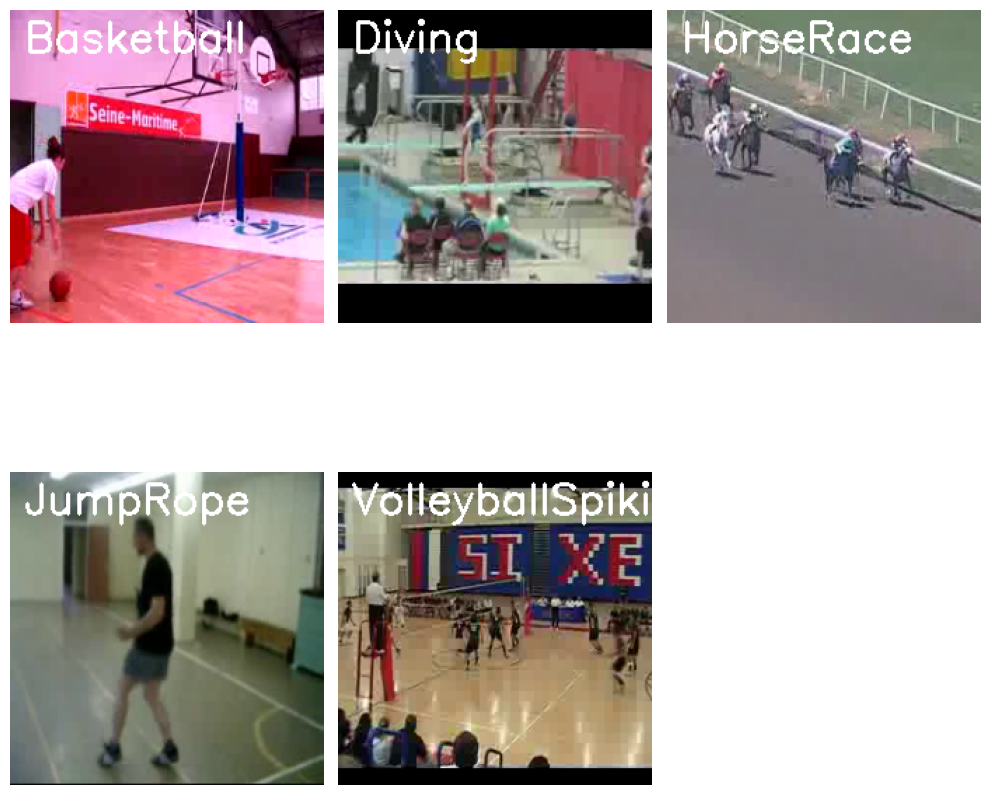

In [4]:
plt.figure(figsize=(10, 10))
for counter, selected_class_name in enumerate(classes, 1):
    video_files_names_list = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    bgr_frame = cv2.resize(bgr_frame, (224, 224))
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, counter)
    plt.imshow(rgb_frame)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

sequence_length = 15

In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frames_list.append(frame)
    video_reader.release()
    return frames_list

In [6]:
def create_dataset():
    features = []
    labels = []
    for class_name in classes:
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name))
        for file_name in files_list:
            video_file_path = os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(class_name)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels

In [7]:
features, labels = create_dataset()

X = []
for feature_list in features:
    x = []
    for feature in feature_list:
        feature = cv2.resize(feature, (224, 224))
        x.append(feature)
    x = np.array(x)
    X.append(x)
X = np.array(X)

print("Before", features.shape)
print("After", X.shape)

Extracting Data of Class: Basketball
Extracting Data of Class: Diving
Extracting Data of Class: HorseRace
Extracting Data of Class: JumpRope
Extracting Data of Class: VolleyballSpiking
Before (681, 15, 240, 320, 3)
After (681, 15, 224, 224, 3)


In [8]:
X = X.astype(np.float32)
mean = np.mean(X)
X -= mean
std = np.std(X, axis=0)
X /= std


In [9]:
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
for label in np.unique(labels):
    print(f"{encoder.transform([label])[0]} : {label}")

0 : Basketball
1 : Diving
2 : HorseRace
3 : JumpRope
4 : VolleyballSpiking


In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

del X, y, features, labels

In [13]:
xception = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in xception.layers:
    layer.trainable = False

model = Sequential([
    TimeDistributed(xception, input_shape=(sequence_length, 224, 224, 3), name="Xception"),
    TimeDistributed(Flatten(), name="Flatten"),
    LSTM(180, activation="relu"),
    Dropout(0.2),
    Dense(5, activation="softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

plot_model(model, show_layer_names=True, dpi=100)

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=7, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=50, batch_size=5, validation_split=0.2, callbacks=[es])

Epoch 1/50


I0000 00:00:1751299764.318488    2858 service.cc:148] XLA service 0x7dbf44002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751299764.319264    2858 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751299775.040242    2858 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751299784.577732    2858 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87/87 ━━━━━━━━━━━━━━━━━━━━ 165s 911ms/step - accuracy: 0.1799 - loss: 964.2979 - val_accuracy: 0.2110 - val_loss: 572.2316
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.1989 - loss: 523.3102 - val_accuracy: 0.2936 - val_loss: 343.4276
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.2148 - loss: 404.4357 - val_accuracy: 0.2385 - val_loss: 118.5991
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.1830 - loss: 333.3410 - val_accuracy: 0.2844 - val_loss: 69.7731
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.3215 - loss: 150.5228 - val_accuracy: 0.3761 - val_loss: 42.2310
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4305 - loss: 106.7152 - val_accuracy: 0.5596 - val_loss: 16.6436
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.4506 - loss: 93.2799 - val_accuracy: 0.6147 - val_loss: 14.6213
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 432ms/step - accuracy: 0.4764 - loss: 49.4

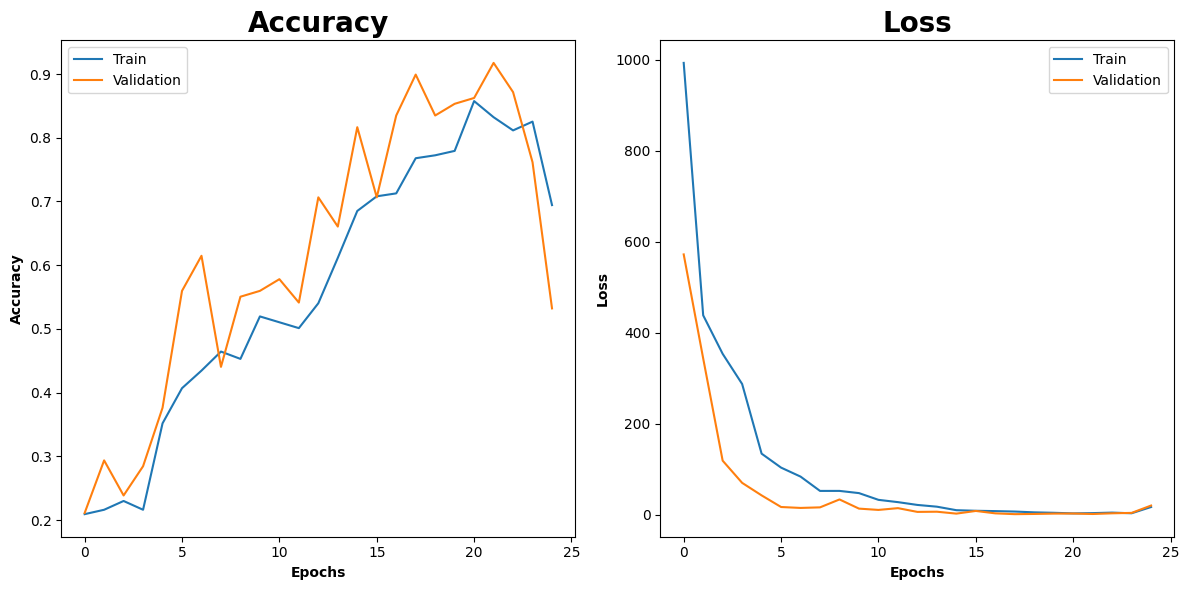

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy", weight="bold", fontsize=20)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.subplot(1, 2, 2)
plt.title("Loss", weight="bold", fontsize=20)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.tight_layout()
plt.show()

In [15]:
prediction = model.predict(x_test)

y_hat = []
for p in prediction:
    res = np.argmax(p)
    y_hat.append(res)
y_hat = np.array(y_hat)

5/5 ━━━━━━━━━━━━━━━━━━━━ 63s 8s/step


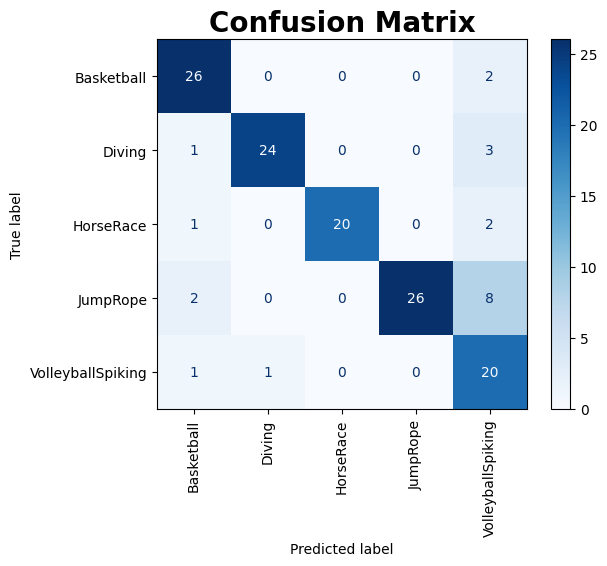

In [16]:
matrix = confusion_matrix(y_test, y_hat)
figure = ConfusionMatrixDisplay(matrix,
                               display_labels=["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.xticks(rotation=90)
plt.show()


In [17]:
report = classification_report(y_test, y_hat)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        28
           1       0.96      0.86      0.91        28
           2       1.00      0.87      0.93        23
           3       1.00      0.72      0.84        36
           4       0.57      0.91      0.70        22

    accuracy                           0.85       137
   macro avg       0.87      0.86      0.85       137
weighted avg       0.89      0.85      0.85       137



In [18]:
model.save("human_activity_xception.h5")

In [19]:
def human_activity_prediction(video_path, mean, std):
    frames = frames_extraction(video_path)
    if len(frames) != sequence_length:
        raise ValueError(f"Expected {sequence_length} frames but got {len(frames)} frames from the video.")
    preprocessed_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (224, 224))
        preprocessed_frames.append(resized_frame)
    
    preprocessed_frames = np.array(preprocessed_frames).astype(np.float32)
    preprocessed_frames -= mean
    preprocessed_frames /= std
    
    preprocessed_frames = np.expand_dims(preprocessed_frames, axis=0)
    
    predicted_probabilities = model.predict(preprocessed_frames)[0]
    print(predicted_probabilities)
    predicted_label = np.argmax(predicted_probabilities)
    predicted_class = encoder.inverse_transform([predicted_label])[0]
    
    print(predicted_class)

path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/Basketball/v_Basketball_g02_c02.avi"
human_activity_prediction(path, mean, std)

path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/Basketball/v_Basketball_g02_c01.avi"
human_activity_prediction(path, mean, std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[1.0000000e+00 1.2076200e-16 0.0000000e+00 1.4292798e-14 1.5379958e-09]
Basketball
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
[1.0000000e+00 5.2305560e-16 0.0000000e+00 3.2350753e-17 1.5152398e-14]
Basketball


In [21]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import os

# Define the classes (same as in training)
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]

# Initialize LabelEncoder (same as used during training)
encoder = LabelEncoder()
encoder.fit(classes)

# Sequence length (number of frames to extract, as in training)
sequence_length = 15

# Load the saved model
model = load_model("human_activity_xception.h5")

# Function to extract frames from the input video
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frames_list.append(frame)
    video_reader.release()
    return frames_list

# Function to test the model on an input video and generate an output video with the predicted label
def test_model_and_generate_video(input_video_path, output_video_path, mean, std):
    # Extract frames
    frames = frames_extraction(input_video_path)
    if len(frames) != sequence_length:
        raise ValueError(f"Expected {sequence_length} frames but got {len(frames)} frames from the video.")
    
    # Preprocess frames
    preprocessed_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (224, 224))
        preprocessed_frames.append(resized_frame)
    
    preprocessed_frames = np.array(preprocessed_frames).astype(np.float32)
    preprocessed_frames -= mean
    preprocessed_frames /= std
    preprocessed_frames = np.expand_dims(preprocessed_frames, axis=0)
    
    # Predict the action
    predicted_probabilities = model.predict(preprocessed_frames)[0]
    predicted_label = np.argmax(predicted_probabilities)
    predicted_class = encoder.inverse_transform([predicted_label])[0]
    print(f"Predicted Class: {predicted_class}")
    print(f"Prediction Probabilities: {predicted_probabilities}")
    
    # Create output video with the predicted label overlaid
    video_reader = cv2.VideoCapture(input_video_path)
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    frame_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    while video_reader.isOpened():
        ret, frame = video_reader.read()
        if not ret:
            break
        # Overlay the predicted label on the frame
        cv2.putText(frame, f"Action: {predicted_class}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        out.write(frame)
    
    # Release resources
    video_reader.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Output video saved as: {output_video_path}")

# Example usage
# Note: Replace `mean` and `std` with the actual values from training
# These should be the same mean and std used during training for consistent preprocessing
mean = 0.0  # Replace with actual mean from training
std = 1.0   # Replace with actual std from training

input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/Basketball/v_Basketball_g02_c02.avi"
output_video_path = "output_basketball_predicted.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/HorseRace/v_HorseRace_g02_c01.avi"
output_video_path = "output_horserace_predicted.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
Predicted Class: Basketball
Prediction Probabilities: [1. 0. 0. 0. 0.]
Output video saved as: output_basketball_predicted.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted Class: JumpRope
Prediction Probabilities: [4.e-45 0.e+00 0.e+00 1.e+00 0.e+00]
Output video saved as: output_horserace_predicted.avi


In [22]:
# Test the model on the HorseRace video
input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/HorseRace/v_HorseRace_g02_c01.avi"
output_video_path = "output_horserace_predicted_corrected.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predicted Class: JumpRope
Prediction Probabilities: [4.e-45 0.e+00 0.e+00 1.e+00 0.e+00]
Output video saved as: output_horserace_predicted_corrected.avi


In [23]:
# Test the model on the HorseRace video
input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/JumpRope/v_JumpRope_g01_c02.avi"
output_video_path = "output_jumprope_predicted_corrected.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted Class: Basketball
Prediction Probabilities: [1. 0. 0. 0. 0.]
Output video saved as: output_jumprope_predicted_corrected.avi
